In [2]:
import numpy as np
import astropy.units as u
import time
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
import poppy
import skimage
from skimage.registration import phase_cross_correlation
import copy
from importlib import reload
import matplotlib.pyplot as plt
import multiprocessing

import magpyx
from magpyx.utils import ImageStream
import purepyindi
from purepyindi import INDIClient
client0 = purepyindi.INDIClient('localhost', 7624)
client0.start()

from IPython.display import clear_output, display
import subprocess
import glob
from pathlib import Path
import os
cwd = os.getcwd()

from math_module import xp, xcipy, np_array
import utils
import fsm_utils
import cam_utils
from imshows import imshow1, imshow2, imshow3
from matplotlib.patches import Circle

wavelength = 633e-9
fl = 425e-3
fsm_pupil_diam = 7.1e-3
as_per_lamD = (wavelength/fsm_pupil_diam*u.radian).to(u.arcsec)
print(as_per_lamD)

pxscl_lamD = 3.45e-6 / (fl * wavelength/fsm_pupil_diam)
print(1/pxscl_lamD)

zero = np.array([[0,0,0]]).T
v_bias = np.array([[50,50,50]]).T

pxscl_lamD * as_per_lamD

/opt/conda/envs/km310gpu/lib/python3.10/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


18.389524275269295 arcsec
10.982853643600734


<Quantity 1.6743849 arcsec>

# Setup FSM Interface

In [7]:
fsm_bias_channel = ImageStream('dm00disp00')

In [8]:
fsm_bias_channel.write(v_bias)

In [50]:
fsm_bias_channel.write(zero)

# Setup the camera parameters

In [5]:
reload(cam_utils)
cam = cam_utils.CAM('campupil')


In [3]:
npsf = 50
cam.set_roi(575, 900, npsf, client0)

In [4]:
cam.set_exptime(0.0001, client0)

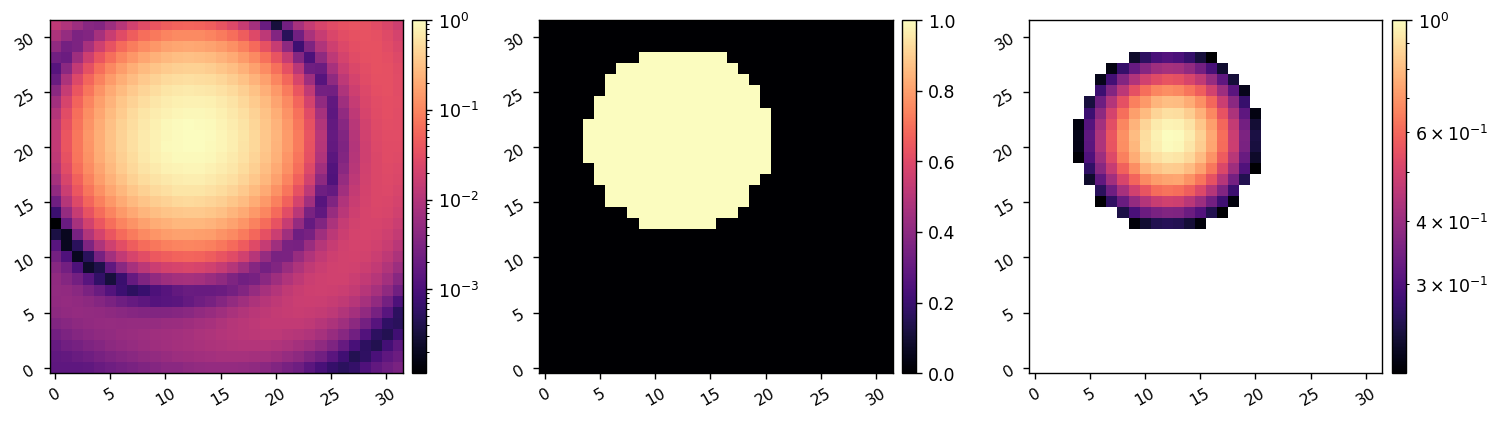

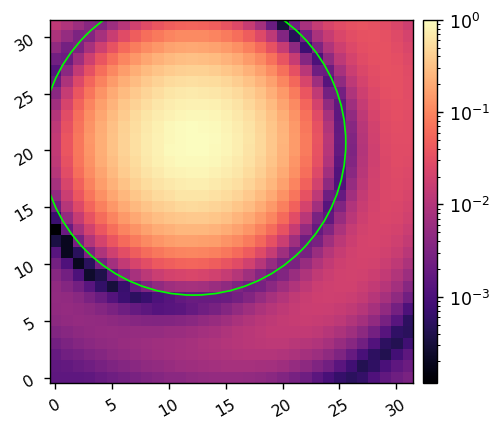

In [5]:
cam.Nframes = 1000
im_bias = cam.snap()

reload(utils)
cen = utils.centroid(im_bias, thresh=0.2, plot=True)
imshow1(im_bias, lognorm=True, patches=[Circle(cen, 1.22/pxscl_lamD, fill=False, color='lime')])


# Setup and record the modulation

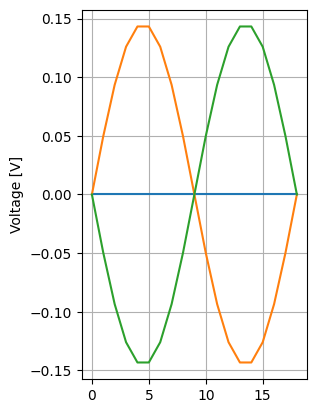

Saved data to:  /opt/MagAOX/calib/dm/fsm/fsm_cube.fits


In [9]:
# Define a sine wave
samps_per_wave = 19
amp = 1*u.arcsec

volt_commands = np.zeros((samps_per_wave, 3, 1))
wave = amp * np.sin(2*np.pi * np.arange(samps_per_wave)/(samps_per_wave-1))
for i in range(samps_per_wave):
    # volt_commands[i] = fsm_utils.get_fsm_volts(tip=wave[i], tilt=0*u.arcsec, dZ=0*u.um)
    volt_commands[i] = fsm_utils.get_fsm_volts(tip=0*u.arcsec, tilt=wave[i], dZ=0*u.um)

plt.subplot(122)
# plt.plot(wave)
plt.plot(volt_commands[:,0])
plt.plot(volt_commands[:,1])
plt.plot(volt_commands[:,2])
plt.ylabel('Voltage [V]')
plt.grid()
plt.show()

utils.save_fits('/opt/MagAOX/calib/dm/fsm/fsm_cube.fits', volt_commands[:-1])


In [4]:
t_total = 2
sin_freq = 3

fsm_utils.set_fsm_mod_amp(4, client0)
fsm_utils.set_fsm_mod_rate(sin_freq*18, client0)


In [5]:
fsm_utils.start_fsm_mod(client0)

In [6]:
fsm_utils.stop_fsm_mod(client0)

# Run the experiment.
### Define and make experiment directory if required

In [7]:
# Setup the directories to which the FSM and campupil data will be stored.

exp_dir = f'sin-mod-{sin_freq:.2f}'
exp_path = Path(f'{cwd}/data/{exp_dir}')

subprocess.run(['mkdir',str(exp_path)])

CompletedProcess(args=['mkdir', '/home/uasal/Projects/fsm-exps/data/sin-mod-3.00'], returncode=0)

In [8]:
reload(fsm_utils)

t_meas = 2

fsm_utils.start_fsm_mod(client0, delay=0.5)
fsm_utils.toggle_telem_fsm(1, client0)
fsm_utils.toggle_telem_campupil(1, client0)

time.sleep(t_meas)

fsm_utils.toggle_telem_campupil(0, client0)
fsm_utils.toggle_telem_fsm(0, client0)
fsm_utils.stop_fsm_mod(client0)



# Extract and analyze data

In [9]:
# Decompress the .xrif files from the telem_* apps into the desired data directories

subprocess.run(['xrif2fits','-d','/opt/MagAOX/telem/campupil/','-D',exp_path])
clear_output()
subprocess.run(['xrif2fits','-d','/opt/MagAOX/telem/fsm/','-D',exp_path])
clear_output()

In [58]:
subprocess.run(['rm','/opt/MagAOX/telem/campupil/'+"*"+'.xrif'])
# subprocess.run(['rm','/opt/MagAOX/telem/fsm/\*.xrif'])

rm: cannot remove '/opt/MagAOX/telem/campupil/\*.xrif': No such file or directory


CompletedProcess(args=['rm', '/opt/MagAOX/telem/campupil/\\*.xrif'], returncode=1)

In [62]:
subprocess.run('sudo rm /opt/MagAOX/telem/campupil/*.xrif', shell=True)

sudo: a terminal is required to read the password; either use the -S option to read from standard input or configure an askpass helper
sudo: a password is required


CompletedProcess(args='sudo rm /opt/MagAOX/telem/campupil/*.xrif', returncode=1)

In [60]:
subprocess.run(['rm','/opt/MagAOX/telem/fsm/dm00disp10_20250129193151881462693.xrif'])

rm: cannot remove '/opt/MagAOX/telem/fsm/dm00disp10_20250129193151881462693.xrif': No such file or directory


CompletedProcess(args=['rm', '/opt/MagAOX/telem/fsm/dm00disp10_20250129193151881462693.xrif'], returncode=1)

In [10]:
cam_data_fnames = sorted(glob.glob(str(exp_path/'campupil*20250129*.fits')))
fsm_data_fnames = sorted(glob.glob(str(exp_path/'dm00disp10*20250129*.fits')))
# cam_data_fnames
# fsm_data_fnames

In [12]:
fsm_start_time = float(fsm_data_fnames[0].split("_")[1][12:-5])/1e9
print(fsm_start_time)

fsm_commands = []
fsm_times = []
for fname in fsm_data_fnames:
    fsm_commands.append(fits.getdata(fname))
    t_hr = float(fname.split("_")[1][8:10])
    t_min = float(fname.split("_")[1][10:12])
    t_sec = float(fname.split("_")[1][12:-5])/1e9
    fsm_times.append( 3600*t_hr + 60*t_min + t_sec )
fsm_commands = np.array(fsm_commands) 
fsm_times = np.array(fsm_times)
fsm_start = fsm_times[0]
rel_fsm_times = fsm_times - fsm_start

45.810699173


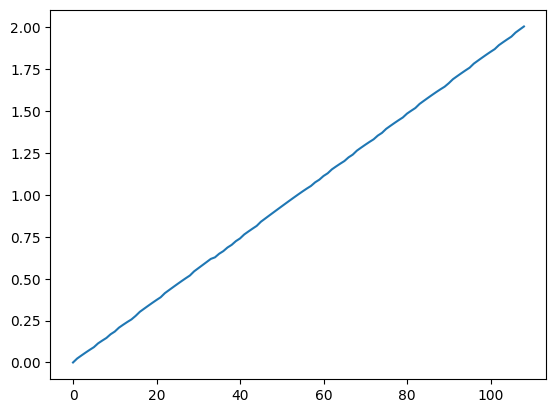

In [13]:
plt.plot(rel_fsm_times)

In [14]:
import astropy.io.fits as fits

cam_start_time = float(cam_data_fnames[0].split("_")[1][12:-5])/1e9
print(cam_start_time)

frames = []
cam_times = []
for fname in cam_data_fnames:
    frames.append(fits.getdata(fname))
    t_hr = float(fname.split("_")[1][8:10])
    t_min = float(fname.split("_")[1][10:12])
    t_sec = float(fname.split("_")[1][12:-5])/1e9
    cam_times.append( 3600*t_hr + 60*t_min + t_sec )
frames = np.array(frames) 
cam_times = np.array(cam_times)
cam_start = cam_times[0]
rel_cam_times = cam_times - fsm_start

45.849428715


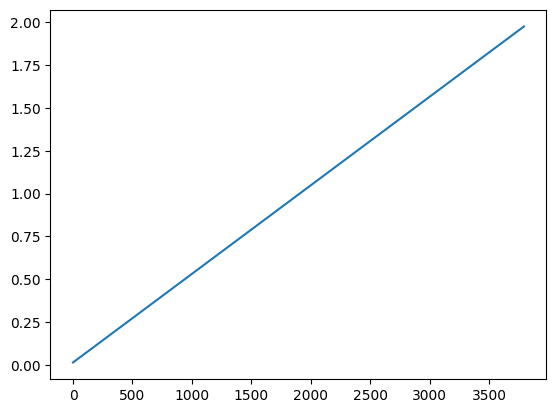

In [76]:
plt.plot(rel_cam_times)

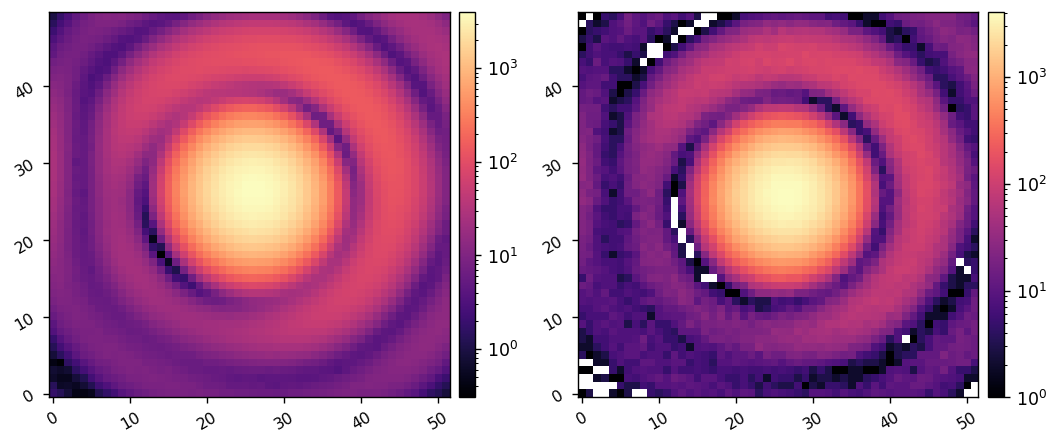

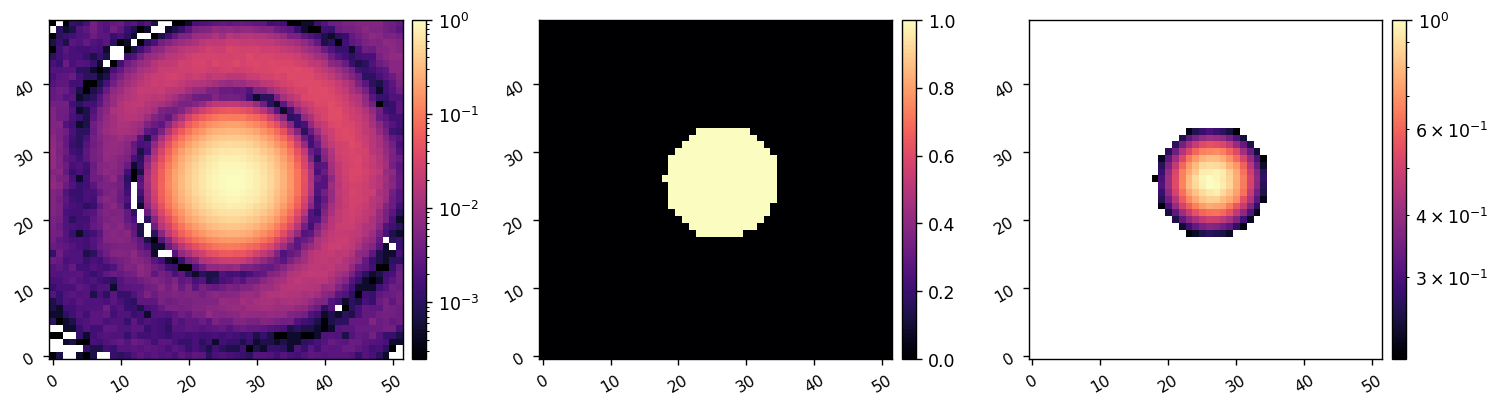

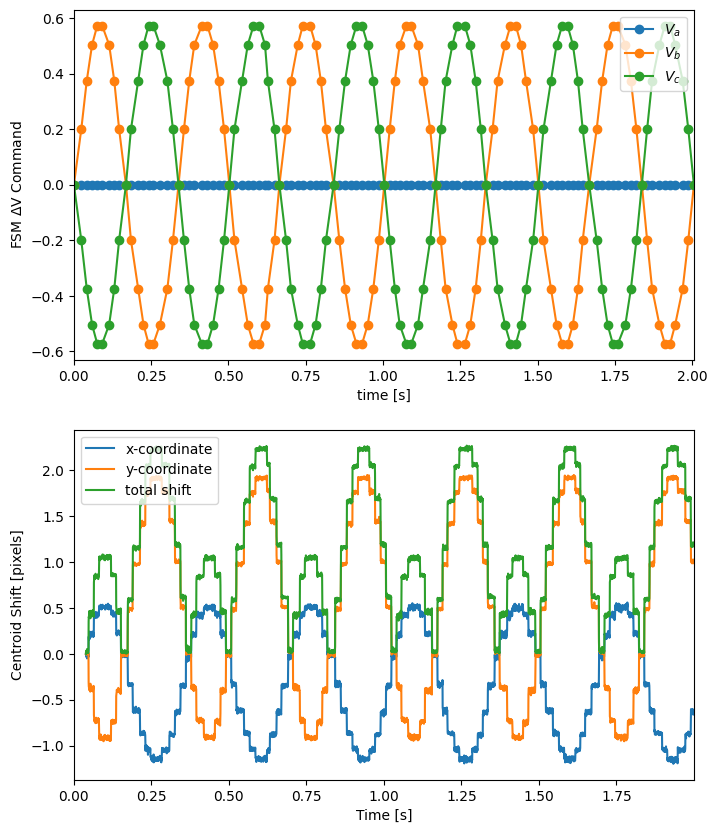

In [15]:
cthresh = 0.2

N = len(cam_data_fnames)
mean_frame = np.mean(frames, axis=0)
imshow2(mean_frame, frames[0], lognorm=True)

shift_pix = []
cen_0 = utils.centroid(frames[0].astype(float), thresh=cthresh, plot=True)
for i in range(N):
    cen = utils.centroid(frames[i].astype(float), thresh=cthresh, plot=0)
    shift = cen - cen_0
    shift_pix.append(shift)
shift_pix = np.array(shift_pix)

shift_pix = shift_pix - shift_pix[0]
# shift_pix[:,0] = shift_pix[:,0] - shift_pix[0,0]
# shift_pix[:,1] = shift_pix[:,1] - shift_pix[0,1]
shift_as = shift_pix * pxscl_lamD * as_per_lamD # pixels * (lamD/pixel) * (as/lamD)

total_shift_pix = np.sqrt( np.sum( np.square(shift_pix), axis=1) )
total_shift_as = np.sqrt( np.sum( np.square(shift_as), axis=1) )

fig = plt.figure(figsize=(8,10))
plt.subplot(211)
plt.plot(rel_fsm_times, fsm_commands[:,0], '-o', label='$V_a$')
plt.plot(rel_fsm_times, fsm_commands[:,1], '-o', label='$V_b$')
plt.plot(rel_fsm_times, fsm_commands[:,2], '-o', label='$V_c$')
plt.ylabel('FSM $\Delta$V Command')
plt.xlabel('time [s]')
plt.xlim([0,rel_fsm_times.max()])
# plt.xlim([0, 1])
plt.legend()

plt.subplot(212)
plt.plot(rel_cam_times, shift_pix[:,0], label='x-coordinate')
plt.plot(rel_cam_times, shift_pix[:,1], label='y-coordinate')
plt.plot(rel_cam_times, total_shift_pix, label='total shift')
# plt.plot(rel_cam_times, total_shift_as, label='total shift')
plt.ylabel('Centroid Shift [pixels]')
plt.xlabel('Time [s]')
plt.xlim([0, rel_cam_times.max()])
# plt.xlim([0, 1])
plt.legend()

plt.show()

[ 5.80926523e-01  2.99889415e+00 -4.50317718e-02  1.20764426e-03]
[-5.80926522e-01  2.99889414e+00 -4.50317185e-02 -1.20764344e-03]


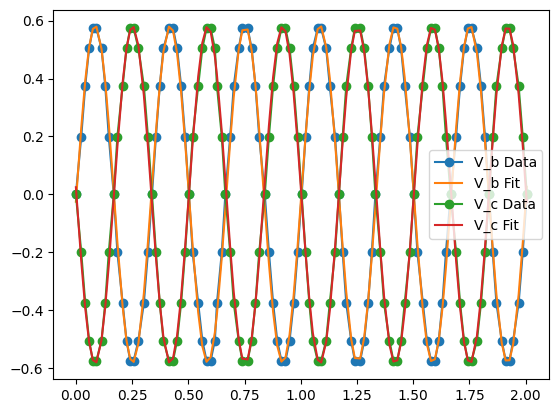

[ 0.84027244  3.0050611  -0.33448867 -0.32003149]
[-1.42217572  3.00516025 -0.33671752  0.50393958]


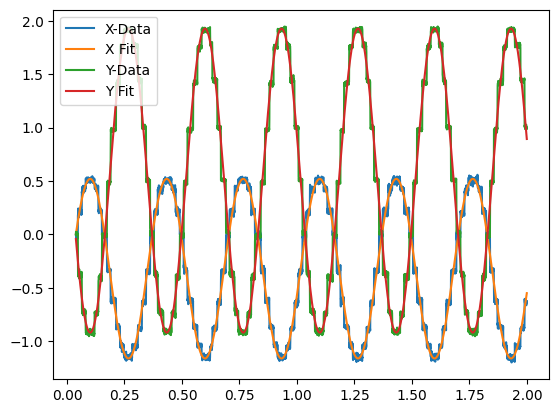

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def sine_func(x, amp, freq, phase, offset): 
    return amp * np.sin(2*np.pi * freq * x + phase) + offset 

x = rel_fsm_times
data_names = ['V_b', 'V_c']
fsm_data_phase = 0
for i in range(2):
    y = fsm_commands[:,i+1][:,0]

    amp0 = (y.max() - y.min())/2
    freq0 = sin_freq
    offset0 = y.max() - amp0
    # print(amp0, freq0, offset0)

    popt, _ = curve_fit(
        sine_func, 
        x, y, 
        p0=[amp0, freq0, 0, offset0],
        maxfev=100000,
    ) 
    print(popt)
    fsm_data_phase += popt[2]/2

    # Plot results
    plt.plot(x, y, '-o', label=data_names[i]+' Data')
    plt.plot(x, sine_func(x, *popt), label=data_names[i]+' Fit')
    plt.legend()
plt.show()

x = rel_cam_times
data_names = ['X', 'Y']
cam_data_phase = 0
for i in range(2):
    y = shift_pix[:,i]

    amp0 = (y.max() - y.min())/2
    freq0 = sin_freq
    offset0 = y.max() - amp0

    popt, _ = curve_fit(
        sine_func, 
        x, y, 
        p0=[amp0, freq0, 0, offset0],
        maxfev=100000,
    ) 
    print(popt)
    cam_data_phase += popt[2]/2

    # Plot results
    plt.plot(x, y, label=data_names[i]+'-Data')
    plt.plot(x, sine_func(x, *popt), label=data_names[i]+' Fit')
    plt.legend()
plt.show()

In [17]:
(fsm_data_phase - cam_data_phase) * 180/np.pi

np.float64(16.64851207040183)